In [3]:
import os
import warnings
from pprint import pprint

In [4]:
import descarteslabs as dl

In [5]:
# *************FIND COUNTRY BOUNDARY ***************
matches = dl.places.find('burundi')
aoi = matches[0]
pprint(aoi)

# This area of interest just gives us some basic properties such as bounding boxes.
# To access a GeoJSON Geometry object of that place, we call the `Places.shape` method, in this case
# accessing a low-resolution version of this particular shape.
shape = dl.places.shape(aoi['slug'], geom='low')

{'bbox': [29.001302, -4.468538, 30.849959, -2.309987],
 'id': 85632285,
 'name': 'Burundi',
 'path': 'continent:africa_country:burundi',
 'placetype': 'country',
 'slug': 'africa_burundi'}


In [64]:
# import json

# *************FIND MATCHING SATELLITE IMAGES ***************
# PRODUCTS


# See what satellite products are available 
products = dl.metadata.available_products()

# isolate landsat 8 products
landsat_products = []
for product in products:
  if 'LC08'in product: 
    landsat_products.append(product)

# Isolate images from Burundi's dry season, from June to September.
feature_collection = dl.metadata.search(
    products= landsat_products, 
    start_time='2017-06-01',
    end_time='2017-09-30',
    cloud_fraction= .2,
    place=aoi['slug'])

# Through visual inspection, I identified the best images to mosaic from the subset. 

north_east = 'landsat:LC08:01:RT:TOAR:meta_LC08_L1TP_172062_20170701_20170701_01_RT_v1'
south_east = 'landsat:LC08:01:RT:TOAR:meta_LC08_L1TP_172063_20170701_20170701_01_RT_v1'
north_west = 'landsat:LC08:01:T1:TOAR:meta_LC08_L1TP_173062_20170606_20170616_01_T1_v1'
south_west = 'landsat:LC08:01:T1:TOAR:meta_LC08_L1TP_173063_20170606_20170616_01_T1_v1'

ids = [north_east, south_east, north_west, south_west]


In [65]:
# *************OUTPUT ARRAY ***************

# Rasterize the features.
#  * Select swir2, swir1, red, alpha. This combination is known to be good for identifying urban areas
#  * https://landsat.usgs.gov/what-are-band-designations-landsat-satellites
#  * https://blogs.esri.com/esri/arcgis/2013/07/24/band-combinations-for-landsat-8/
#  * Scale the incoming data with range [0, 10000] down to [0, 4000] (40% TOAR)
#  * Choose an output type of "Byte" (uint8)
#  * Choose 60m resolution
#  * Apply a cutline of Burundi's boundary 


arr, meta = dl.raster.ndarray(
    ids,
    bands=['swir2', 'swir1', 'red', 'alpha'],
    scales=[[0,4000], [0, 4000], [0, 4000], None],
    data_type='Byte',
    resolution=30,
    cutline=shape['geometry'],
    srs="EPSG:4326"
)

# '''
# for id in ids:
#     arr, meta = dl.raster.raster(
#         id,
#         bands=['swir2', 'swir1', 'red', 'alpha'],
#         scales=[[0,4000], [0, 4000], [0, 4000], None],
#         data_type='Byte',
#         resolution=60,
#         cutline=shape['geometry'],
#         save= "true",
#     )
#  '''

# Note: A value of 1 in the alpha channel signifies where there is valid data.
# We use this throughout the majority of our imagery as a standard way of specifying
# valid or nodata regions. This is particularly helpful if a value of 0 in a particular
# band has meaning, rather than specifying a lack of data.



BadRequestError: {
  "message": "Width or height is <= 0: width: 0.630564716363 height: 0.618499365422", 
  "status_code": 400
}


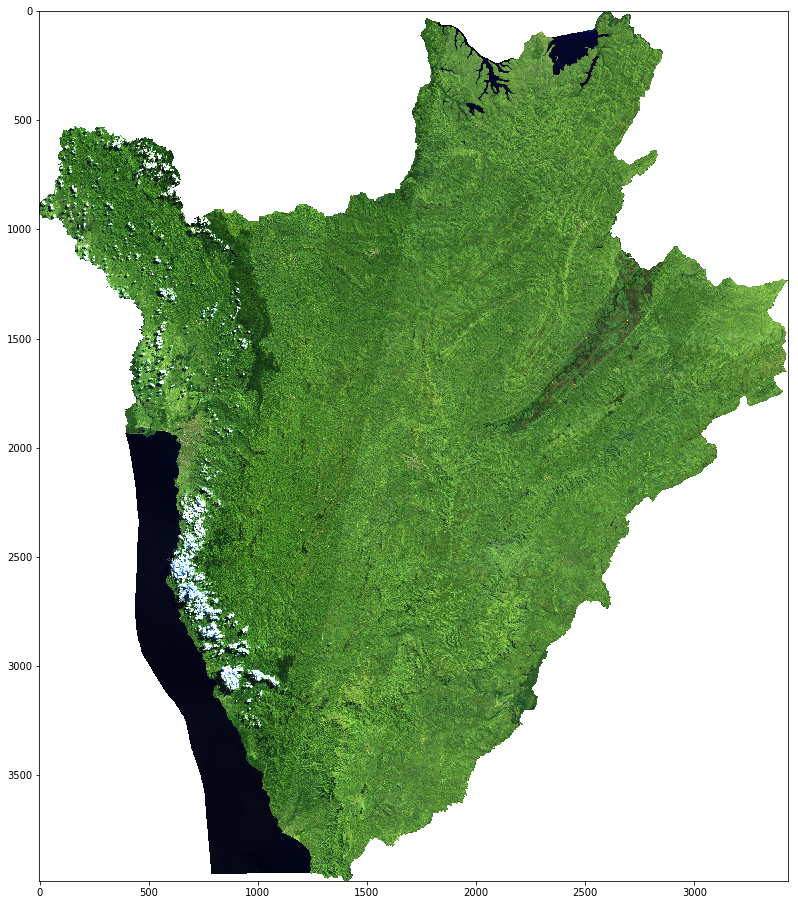

In [54]:
# *************PLOT SINGLE IMAGE ***************

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[16,16])
plt.imshow(arr)

### Train Model